# DCGAN

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
device = torch.device("cuda")

In [ ]:
num_epochs = 300

lr = 0.0002
betas = (0.5, 0.999)

noise_size = 100
batch_size = 128
num_val_samples = 25
num_classes = 10
num_input_channels = 1

## Dataset

In [ ]:
tf = transforms.Compose([
                         transforms.Resize(32),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=0.5, std=0.5)
])

dataset = datasets.MNIST("data", train=True, download=True, transform=tf)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=4)


## Networks

### Exercise 1

The generator takes random noise as input and gives an image as output. Your exercise is to create the generator model.

It should follow these guidelines:
* The input will be a vector with random noise of size `noise_size`
* You should first apply a fully connected with output size 512\*4\*4 (channels\*height\*width)
* Then you should apply 3 blocks of:
    * TransposedConvolution with kernel size 4, stride 2 and padding 1. For the first 2 blocks, the output channels should be 256 and 128. For the third block, the output channels should be the correct one to generate images of the dataset.
    * BatchNorm2d except for the last block.
    * ReLU activation for the first 2 blocks and Tanh for the third block.

**Hint**: Remember to use reshape where necessary

In [ ]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
      
        self.fc = nn.Linear(noise_size, 512*4*4)
        # [512*4*4]
        # Reshape
        # [512, 4, 4]
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # [256, 8, 8] 
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # [128, 16, 16] 
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size=4, stride=2, padding=1, bias=False),  # [1, 32, 32] 
            nn.Tanh(),
        )

    def forward(self, x):

        x = self.fc(x)
        x = x.reshape(-1, 512, 4, 4)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)
        
        return x

### Exercise 2

The discriminator takes an image as input and classifies it between Real or Fake (1 or 0). Your exercise is to create the discriminator model.

It should follow these guidelines:
* The input will be an image of size `[num_input_channels, 32, 32]`
* You should apply 3 blocks of:
    * Convolution with kernel size 4, stride 2 and padding 1. The output channels should be 128, 256 and 512.
    * BatchNorm2d except for the first block.
    * LeakyReLU activation (alpha=0.2)
* Then you should first apply a fully connected with input size 512\*4\*4 (channels\*height\*width) and the correct output size and activation for binary classification


**Hint**: Remember to use reshape/flatten where necessary

In [ ]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_input_channels, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [ ]:
generator = Generator().to(device)
optimizer_g = optim.Adam(generator.parameters(), lr, betas)

discriminator = Discriminator().to(device)
optimizer_d = optim.Adam(discriminator.parameters(), lr, betas)


In [ ]:
criterion = nn.BCELoss()

In [ ]:
def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);

### Exercise 3

Complete the code. Take into account which labels should be used at each step of the training.

In [ ]:
def train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d):

    generator.train()
    discriminator.train()
    
    current_batch_size = real_samples.shape[0]
    label_real = torch.ones(current_batch_size, 1, device=device)
    label_fake = torch.zeros(current_batch_size, 1, device=device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(current_batch_size, noise_size, device=device)
    fake_samples = generator(z)
    
    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples)

    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()
    
    # Update weights
    optimizer_g.step()
    
    ####################
    # OPTIMIZE DISCRIMINATOR
    ####################

    fake_samples = fake_samples.detach()
    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)
    
    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2
    loss_d.backward()

    optimizer_d.step()

    return loss_g.item(), loss_d.item()


In [ ]:
@torch.no_grad()
def evaluate(generator, z_val):
    generator.eval()
    fake_samples = generator(z_val).cpu()

    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    img = (img*0.5+0.5)*255

    img_np = np.transpose(img.numpy().astype(np.uint8), (1, 2, 0))
    return Image.fromarray(img_np)


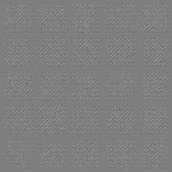

epoch: 1/300 batch: 1/469 G_loss: 2.387946128845215, D_loss: 0.0932595431804657


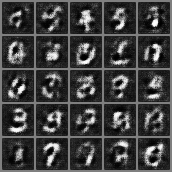

epoch: 1/300 batch: 101/469 G_loss: 2.7363009452819824, D_loss: 0.11153684556484222


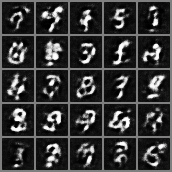

epoch: 1/300 batch: 201/469 G_loss: 1.7784785032272339, D_loss: 0.13513252139091492


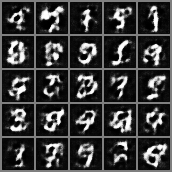

epoch: 1/300 batch: 301/469 G_loss: 1.5408265590667725, D_loss: 0.23664796352386475


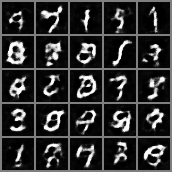

epoch: 1/300 batch: 401/469 G_loss: 2.502666711807251, D_loss: 0.08274048566818237


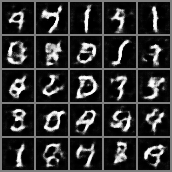

epoch: 2/300 batch: 1/469 G_loss: 1.3521952629089355, D_loss: 0.26027658581733704


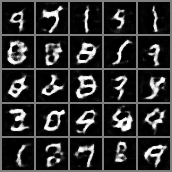

epoch: 2/300 batch: 101/469 G_loss: 2.4195497035980225, D_loss: 0.08982369303703308


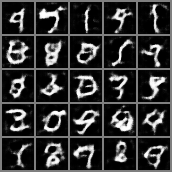

epoch: 2/300 batch: 201/469 G_loss: 1.9069387912750244, D_loss: 0.22231782972812653


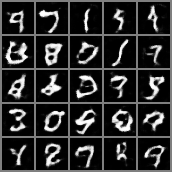

epoch: 2/300 batch: 301/469 G_loss: 2.298114776611328, D_loss: 0.11055684089660645


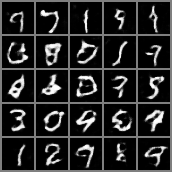

epoch: 2/300 batch: 401/469 G_loss: 2.649521827697754, D_loss: 0.09973004460334778


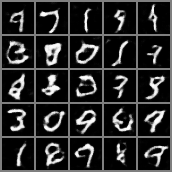

epoch: 3/300 batch: 1/469 G_loss: 3.04367733001709, D_loss: 0.10205189883708954


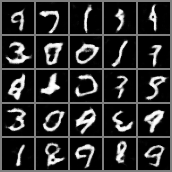

epoch: 3/300 batch: 101/469 G_loss: 4.10087251663208, D_loss: 0.20058156549930573


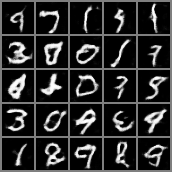

epoch: 3/300 batch: 201/469 G_loss: 1.275371789932251, D_loss: 0.3364616632461548


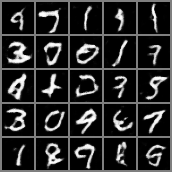

epoch: 3/300 batch: 301/469 G_loss: 2.2440037727355957, D_loss: 0.1461808681488037


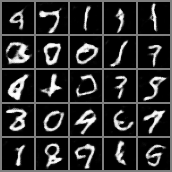

epoch: 3/300 batch: 401/469 G_loss: 2.0732860565185547, D_loss: 0.23119279742240906


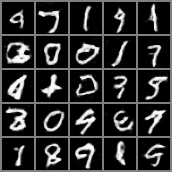

epoch: 4/300 batch: 1/469 G_loss: 1.487338900566101, D_loss: 0.41555818915367126


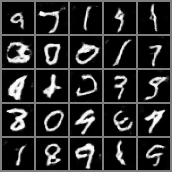

epoch: 4/300 batch: 101/469 G_loss: 3.5284595489501953, D_loss: 0.21505261957645416


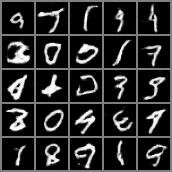

epoch: 4/300 batch: 201/469 G_loss: 1.706058144569397, D_loss: 0.1680617481470108


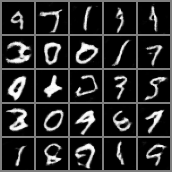

epoch: 4/300 batch: 301/469 G_loss: 3.672990322113037, D_loss: 0.07413715869188309


KeyboardInterrupt: ignored

In [ ]:
z_val = torch.randn(num_val_samples, noise_size, device=device)

for epoch in range(num_epochs):

    for i, (real_samples, labels) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        loss_g, loss_d = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)

        if i % 100 == 0:
            fake_images = evaluate(generator, z_val)
            display(fake_images)

            # Show current loss
            print(f"epoch: {epoch+1}/{num_epochs} batch: {i+1}/{len(dataloader)} G_loss: {loss_g}, D_loss: {loss_d}")
